In [33]:
from pathlib import Path

import cv2 as cv
import exposure_fusion as ef
import matplotlib.pyplot as plt
import numpy as np

from dhdrnet.util import DATA_DIR

%matplotlib inline

4KK2_20150910_151036_908.png

0037_20160716_115039_415.png

0094_20150412_110436_460.png


In [34]:
image_names = [
    "4KK2_20150910_151036_908",
    "0037_20160716_115039_415",
    "0094_20150412_110436_460",
]
exposure_files = [
    (DATA_DIR / "correct_exposures" / "exposures").glob(f"{name}*")
    for name in image_names
]
exposure_files = [
    [
        file
        for file in files
        if any(f"[{ev}]" in file.name for ev in [-3.0, -1.0, 0.0, 1.0, 3.0])
    ]
    for files in exposure_files
]
exposure_files

[[PosixPath('/home/shane/src/DHDRNet/data/correct_exposures/exposures/4KK2_20150910_151036_908[0.0].png'),
  PosixPath('/home/shane/src/DHDRNet/data/correct_exposures/exposures/4KK2_20150910_151036_908[1.0].png'),
  PosixPath('/home/shane/src/DHDRNet/data/correct_exposures/exposures/4KK2_20150910_151036_908[3.0].png'),
  PosixPath('/home/shane/src/DHDRNet/data/correct_exposures/exposures/4KK2_20150910_151036_908[-1.0].png'),
  PosixPath('/home/shane/src/DHDRNet/data/correct_exposures/exposures/4KK2_20150910_151036_908[-3.0].png')],
 [PosixPath('/home/shane/src/DHDRNet/data/correct_exposures/exposures/0037_20160716_115039_415[0.0].png'),
  PosixPath('/home/shane/src/DHDRNet/data/correct_exposures/exposures/0037_20160716_115039_415[1.0].png'),
  PosixPath('/home/shane/src/DHDRNet/data/correct_exposures/exposures/0037_20160716_115039_415[3.0].png'),
  PosixPath('/home/shane/src/DHDRNet/data/correct_exposures/exposures/0037_20160716_115039_415[-1.0].png'),
  PosixPath('/home/shane/src/DHDR

In [41]:
def align_images(images):
    if not isinstance(images, list) or len(images) < 2:
        print("Input has to be a list of at least two images")
        return None

    size = images[0].shape
    for i in range(len(images)):
        if not images[i].shape == size:
            print("Input images have to be of the same size")
            return None

    # Convert images to grayscale
    gray_images = []
    for image in images:
        gray_images.append(cv.cvtColor(image, cv.COLOR_BGR2GRAY))

    model_image = gray_images[0]

    # Find size of images
    sz = model_image.shape

    # Define the motion model
    warp_mode = cv.MOTION_TRANSLATION

    # Define 2x3 or 3x3 matrices and initialize the matrix to identity
    if warp_mode == cv.MOTION_HOMOGRAPHY:
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else:
        warp_matrix = np.eye(2, 3, dtype=np.float32)

    # Specify the number of iterations.
    number_of_iterations = 5000

    # Specify the threshold of the increment in the correlation coefficient between two iterations
    termination_eps = 1e-10

    # Define termination criteria
    criteria = (
        cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT,
        number_of_iterations,
        termination_eps,
    )

    # Run the ECC algorithm. The results are stored in warp_matrix.
    aligned_images = [images[0]]
    for i in range(1, len(images)):
        (cc, warp_matrix) = cv.findTransformECC(
            model_image,
            gray_images[i],
            warp_matrix,
            warp_mode,
            criteria,
            np.ones_like(model_image),
            5,
        )

        if warp_mode == cv.MOTION_HOMOGRAPHY:
            # Use warpPerspective for Homography
            aligned_image = cv.warpPerspective(
                images[i],
                warp_matrix,
                (sz[1], sz[0]),
                flags=cv.INTER_LINEAR + cv.WARP_INVERSE_MAP,
            )
        else:
            # Use warpAffine for Translation, Euclidean and Affine
            aligned_image = cv.warpAffine(
                images[i],
                warp_matrix,
                (sz[1], sz[0]),
                flags=cv.INTER_LINEAR + cv.WARP_INVERSE_MAP,
            )

        aligned_images.append(aligned_image)

    return aligned_images

In [50]:
loaded_image_groups = [
    [cv.imread(str(im_path)) for im_path in exp_group] for exp_group in exposure_files
]
aligned_image_groups = [
    align_images(loaded_images) for loaded_images in loaded_image_groups
]
# fused_images = [
#     ef.exposure_fusion(aligned_images, depth=4)
#     for aligned_images in aligned_image_groups
# ]
weight_maps = [ef.compute_weights(images, None) for images in aligned_image_groups]

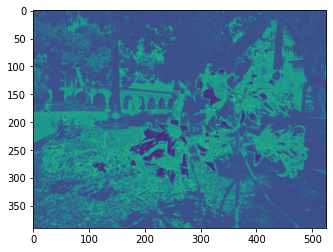

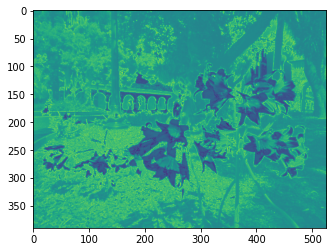

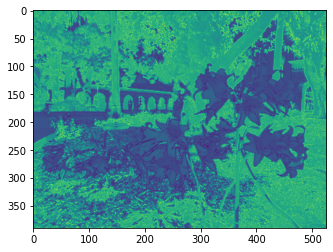

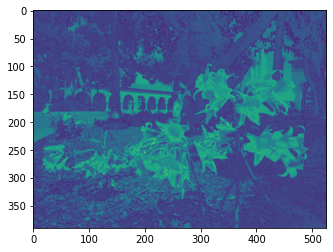

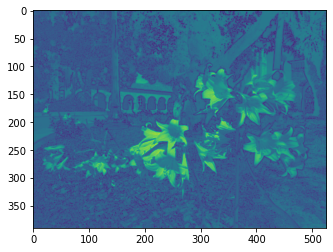

In [52]:
for wm in weight_maps[0]:
    plt.imshow(wm)
    plt.show()